In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


from astropy.io import fits
import dill as pickle
from emcee import EnsembleSampler
import numpy as np
import os
import sys
import math

pwd = os.getcwd()
little_things_root_dir = os.path.dirname(pwd)
sys.path.append(little_things_root_dir)

from little_things_lib.galaxy import Galaxy
from little_things_lib.nfw_mcmc_fitter import (
    EmceeParameters,
    get_mcmc_start_position, 
    generate_nwalkers_start_points, 
    lnprob)
from little_things_lib.plotting import plot_posterior_distributions, plot_walker_paths

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Enter parameters for galaxy in cell below

In [3]:
galaxy_name = 'DDO154'

DEG_PER_PIXEL = 4.17e-4
DISTANCE = 3700 # kpc

# can leave these as any number for now, not used
LUMINOSITY = 1e8  # solar luminositiy
HI_MASS = 1e8  # solar masses

In [4]:
mcmc_params = EmceeParameters(
    ndim=3,
    nwalkers=10, 
    nburn=0,
    niter=200,
    nthin=0,
    nthreads=4
)

In [5]:
"""
Expect the data to be provided in following naming convention in 'data' directory:

2D observed velocity field FITS file: <galaxy_name>_1mom.fits
Bbarolo fit parameters text file: <galaxy_name>_ring_parameters.txt
Stellar velocity curve: <galaxy_name>_stellar_velocities.txt
Gas velocity_curve: <galaxy_name>_gas_velocities.txt

"""


data_dir = os.path.join(little_things_root_dir, 'data')

observed_2d_vel_field_fits_file = os.path.join(data_dir, f'{galaxy_name}_1mom.fits')
ring_parameters_file = os.path.join(data_dir, f'{galaxy_name}_ring_parameters.txt')

stellar_velocities_file = os.path.join(data_dir, f'{galaxy_name}_stellar_velocities.txt')
gas_velocities_file = os.path.join(data_dir, f'{galaxy_name}_gas_velocities.txt')


In [6]:
radii_kpc, test_rotation_curve, inclinations, position_angles, x_centers, y_centers , v_systemics = \
    np.loadtxt(ring_parameters_file, usecols=(0,2,4,5,-4,-3,-2)).T

avg_inclination = np.mean(inclinations)
avg_position_angle = np.mean(position_angles)
avg_x_center = 255
avg_y_center = 225
x_centers = np.array([avg_x_center for i in range(len(inclinations))])
y_centers = np.array([avg_y_center for i in range(len(inclinations))])
v_systemic = np.mean(v_systemics)

observed_2d_vel_field = fits.open(observed_2d_vel_field_fits_file)[0].data

stellar_radii, stellar_vel = np.loadtxt(stellar_velocities_file, unpack=True, usecols =(0,1))
gas_radii, gas_vel = np.loadtxt(gas_velocities_file, unpack=True, usecols = (0,1))

In [7]:
galaxy = Galaxy(
    distance_to_galaxy=DISTANCE,  # [kpc] Look this up for the galaxy 
    deg_per_pixel=DEG_PER_PIXEL ,  # 'CRDELT1' and 'CRDELT2' in the FITS file header (use absolute value)
    galaxy_name=galaxy_name,
    vlos_2d_data=observed_2d_vel_field,
    output_dir='output',
    luminosity=LUMINOSITY,
    HI_mass=HI_MASS)

tilted_ring_params = {
    'v_systemic': v_systemic,
    'radii': radii_kpc,   
    'inclination': inclinations,
    'position_angle': position_angles,
    'x_pix_center': x_centers,
    'y_pix_center': y_centers
}

galaxy.set_tilted_ring_parameters(**tilted_ring_params)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='stellar',
    rotation_curve_radii=stellar_radii,
    rotation_curve_velocities=stellar_vel)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='gas',
    rotation_curve_radii=gas_radii,
    rotation_curve_velocities=gas_vel)

# initialize MCMC start position and bounds
galaxy.set_nfw_prior_bounds(
    rhos_bounds=(1e6, 1e9),   # msun / kpc^3
    rs_bounds=(0.1, 10),  # kpc
    ml_bounds=(0.1, 10),
  
)

In [8]:
v=galaxy.create_2d_velocity_field(
    tilted_ring_params['radii'], 
    v_rot = test_rotation_curve  
)

In [9]:
galaxy.radii/galaxy.kpc_per_pixel

array([  3.82491755,  11.47475265,  19.12458776,  26.77442286,
        34.46139308,  42.11122819,  49.76106329,  57.41089839,
        65.06073349,  72.7105686 ,  80.3604037 ,  88.0102388 ,
        95.69720903, 103.34704413, 110.99687923, 118.64671433,
       126.29654944, 141.59621964, 149.24605474, 156.89588985,
       164.58286007, 172.23269517, 179.88253028, 187.53236538,
       195.18220048, 202.83203558, 210.48187069, 218.13170579,
       225.81867601, 233.46851111, 241.11834622, 248.76818132,
       256.41801642, 264.06785152, 271.71768663, 279.36752173,
       287.05449195, 294.70432706, 302.35416216, 310.00399726,
       317.65383236, 325.30366747, 332.95350257, 340.60333767,
       348.25317277, 355.940143  , 363.5899781 , 371.2398132 ,
       378.88964831, 386.53948341, 394.18931851, 401.83915361,
       409.48898872, 417.17595894, 424.82579404, 432.47562915,
       440.12546425, 447.77529935, 455.42513445])

In [10]:
# This will print warnings if the start points go outside prior bounds

start_point, start_point_radii = get_mcmc_start_position(galaxy)
start_pos = generate_nwalkers_start_points(galaxy, mcmc_params.nwalkers, start_point, start_point_radii)

In [11]:
sampler = EnsembleSampler(
    mcmc_params.nwalkers,
    mcmc_params.ndim, 
    lnprob, 
    args=[galaxy], 
    threads=mcmc_params.nthreads)

# this will break up the fitting procedure into smaller chunks of size batch_size and save progress

batch_size = 20
mcmc_output = []
for batch in range(mcmc_params.niter // batch_size):
    if batch== 0:
        batch_start = start_pos 
    else:
        batch_start = None
        sampler.pool = temp_pool
    mcmc_output += sampler.run_mcmc(batch_start, batch_size)
    temp_pool = sampler.pool
    del sampler.pool
    with open('sampler.pkl', 'wb') as f:
        pickle.dump(sampler, f)
    with open('mcmc_output.pkl', 'wb') as f:
        pickle.dump(mcmc_output, f)
    print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_params.niter}")


Done with steps 0 - 20 out of 200
Done with steps 20 - 40 out of 200
Done with steps 40 - 60 out of 200
Done with steps 60 - 80 out of 200
Done with steps 80 - 100 out of 200
Done with steps 100 - 120 out of 200
Done with steps 120 - 140 out of 200
Done with steps 140 - 160 out of 200
Done with steps 160 - 180 out of 200
Done with steps 180 - 200 out of 200


In [12]:
# example of how to load the pickled objects
with open('sampler.pkl', 'rb') as f:
    sampler = pickle.load(f)
with open('mcmc_output.pkl', 'rb') as f:
    mcmc_output = pickle.load(f)

#### Plot the posterior distributions and walker paths

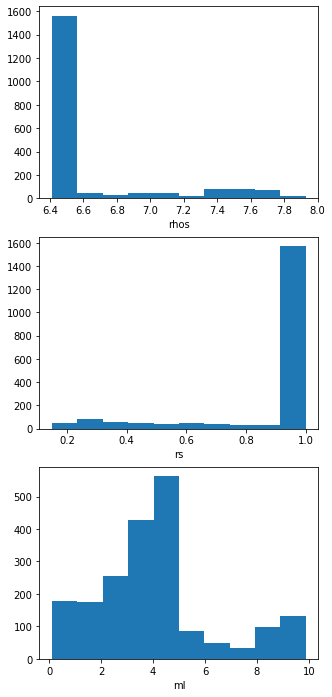

rhos: 6.632520366743742 +/- 0.3929634798806215
rs: 0.8781652234709585 +/- 0.22846228292804166
ml: 4.072692927730749 +/- 2.309563245123478


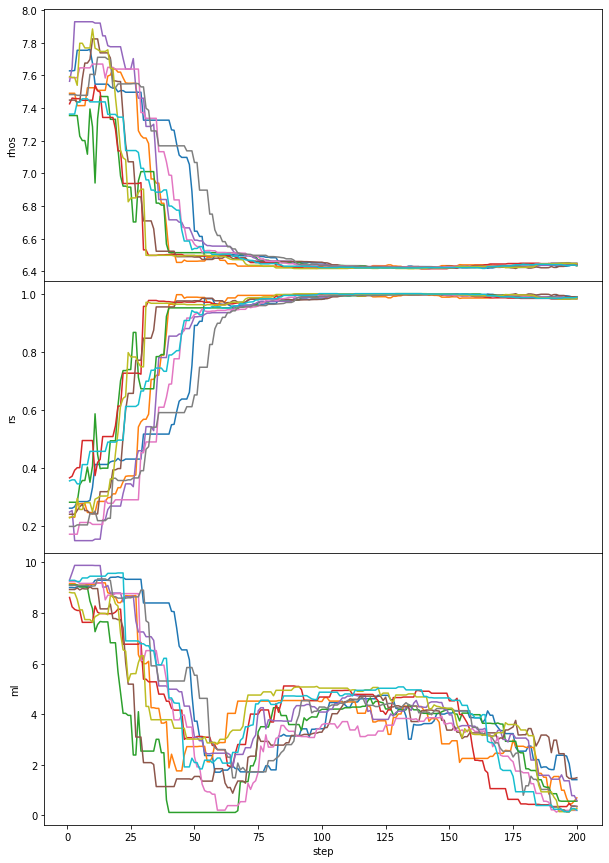

In [13]:
plot_posterior_distributions(sampler, labels=['rhos', 'rs', 'ml'])

plot_walker_paths(
    sampler,
    mcmc_params,
    labels=['rhos', 'rs', 'ml'])

def get_fit_stats(sampler, labels=["rhos", "rs", "ml"]):
    for i, label in enumerate(labels):
        chain = sampler.chain[:, :, i].flatten()
        print(f"{label}: {np.mean(chain)} +/- {np.std(chain)}")
        
get_fit_stats(sampler)

#### Compare observed 2d velocity field with one generated during fitting process

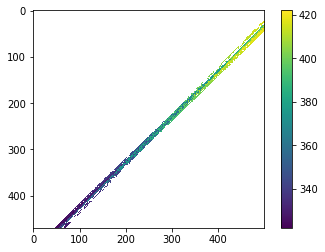

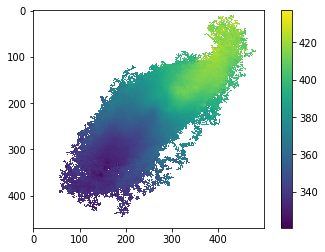

In [14]:
example_2d_field = mcmc_output[-1][9][-1]
plt.imshow(example_2d_field)
plt.colorbar()
plt.show()

plt.imshow(galaxy.vlos_2d_data)
plt.colorbar()
plt.show()


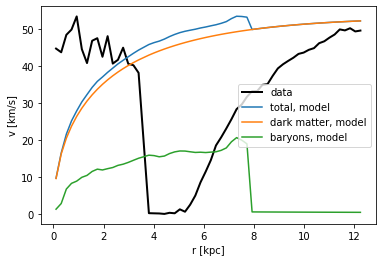

In [15]:
blobs = np.reshape(sampler.blobs, (mcmc_params.niter * mcmc_params.nwalkers,10))
v_dm = np.mean( blobs[:, 4])
v_baryon = np.mean( blobs[:, 5])
v_tot = np.mean( blobs[:, 7])

plt.plot(radii_kpc, test_rotation_curve, linewidth=2., label="data", color="black")

plt.plot(galaxy.radii, v_tot, label="total, model")
plt.plot(galaxy.radii, v_dm, label="dark matter, model")
plt.plot(galaxy.radii, v_baryon, label="baryons, model")
plt.xlabel("r [kpc]")
plt.ylabel("v [km/s]")
plt.legend()

In [16]:
rhos_chain = sampler.chain[:, :, 0].flatten()
rs_chain = sampler.chain[:, :, 1].flatten()

Vmax: 55.081621783577916
Rmax: 20.922233595223382


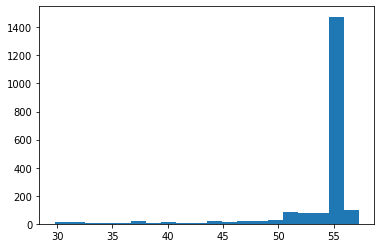

(array([  72.,   73.,   64.,   34.,   32.,   18.,   22.,   16.,   10.,
          26.,   16.,   10.,    2.,   14.,    9.,   13.,   30.,  115.,
         214., 1210.]),
 array([ 3.05146167,  3.97866332,  4.90586498,  5.83306664,  6.76026829,
         7.68746995,  8.6146716 ,  9.54187326, 10.46907492, 11.39627657,
        12.32347823, 13.25067988, 14.17788154, 15.1050832 , 16.03228485,
        16.95948651, 17.88668816, 18.81388982, 19.74109148, 20.66829313,
        21.59549479]),
 <a list of 20 Patch objects>)

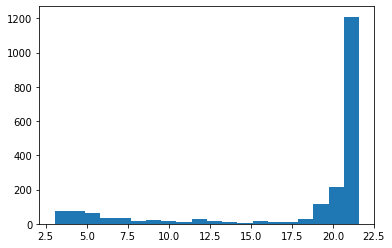

In [18]:
G=4.301e-6 #units of kpc km^2 M_solar^-1 s^-2

# This will pick out values for rhos and rs
rhos_chain = sampler.chain[:, :, 0].flatten()
rs_chain = sampler.chain[:, :, 1].flatten()

# This will find V for every element in Ps and Rs 
Vmax = np.sqrt(0.216 * 4 * np.pi* G * 10**rhos_chain * np.square(10**rs_chain) )
print ("Vmax:", np.median(Vmax))

#This finds the Rmax value*
Rmax = 2.16 * 10**rs_chain
print("Rmax:", np.median(Rmax))

plt.hist(Vmax, bins = 20)
plt.show()
plt.hist(Rmax, bins = 20)